In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import gc
import kagglehub
from tqdm import tqdm

from google.colab import files

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from PIL import Image, UnidentifiedImageError, ImageEnhance

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("farjanakabirsamanta/osteoarthritis-prediction")

print("Path to dataset files:", path)

100%|██████████| 107M/107M [00:05<00:00, 19.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/farjanakabirsamanta/osteoarthritis-prediction/versions/1


In [3]:
#Path

# path = os.getcwd().replace("notebooks", "") ## Local path directory and cookie cutter ds templete
paths = {
    "normal": dict({"valid":f"{path}/Valid/Valid/Normal",
        "train":f"{path}/train/train/Normal",
        "test":f"{path}/test/test/Normal"}),
    "osteoarthritis": dict({"valid":f"{path}/Valid/Valid/Osteoarthritis",
        "train":f"{path}/train/train/Osteoarthritis",
        "test":f"{path}/test/test/Osteoarthritis"})
}

In [4]:
normal = {
    'category_name': 'normal',
    'load_command': dict({
        'valid': [f"{paths['normal']['valid']}" + "/" + f'{i}' for i in os.listdir(paths['normal']['valid'])],
        'train': [f"{paths['normal']['train']}" + "/" + f'{i}' for i in os.listdir(paths['normal']['train'])],
        'test': [f"{paths['normal']['test']}" + "/" + f'{i}' for i in os.listdir(paths['normal']['test'])]
    })
}

osteoarthritis = {
    'category_name': 'osteoarthritis',
    'load_command': dict({
        'valid': [f"{paths['osteoarthritis']['valid']}" + "/" + f'{i}' for i in os.listdir(paths['osteoarthritis']['valid'])],
        'train': [f"{paths['osteoarthritis']['train']}" + "/" + f'{i}' for i in os.listdir(paths['osteoarthritis']['train'])],
        'test': [f"{paths['osteoarthritis']['test']}" + "/" + f'{i}' for i in os.listdir(paths['osteoarthritis']['test'])]
    })
}

categories = [normal, osteoarthritis]

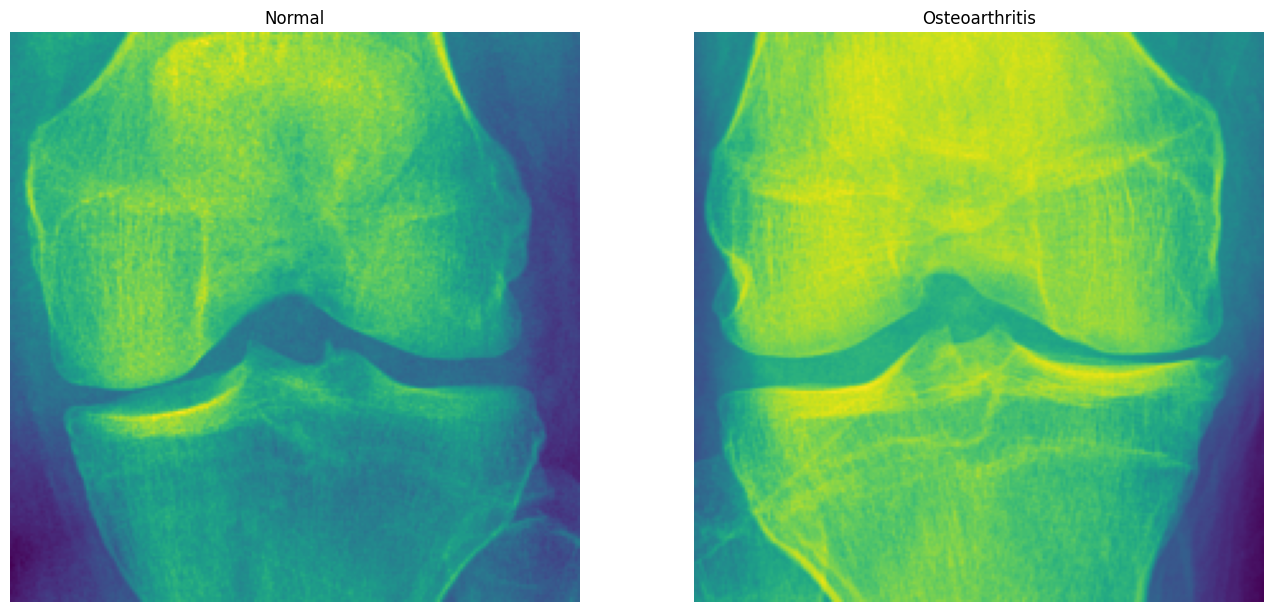



Size of the image
Category: normal
(224, 224)


Size of the image
Category: osteoarthritis
(224, 224)


In [5]:
img1 = Image.open(f"{normal['load_command']['train'][0]}")
img2 = Image.open(f"{osteoarthritis['load_command']['train'][0]}")

def plot_image(img):
  plt.figure(figsize=(10, 10))
  plt.imshow(img, cmap = 'gray')
  plt.axis("off")
  plt.show()

plt.figure(figsize=(25, 10))
for i in range(2):
    plt.subplot(1, 3, i+1)
    plt.imshow([img1, img2][i])
    plt.title(["Normal", "Osteoarthritis"][i])
    plt.axis("off")
plt.show()

for size,name in zip([img1.size, img2.size],categories):
    print('\n')
    print(f"Size of the image\nCategory: {name['category_name']}")
    print(size)

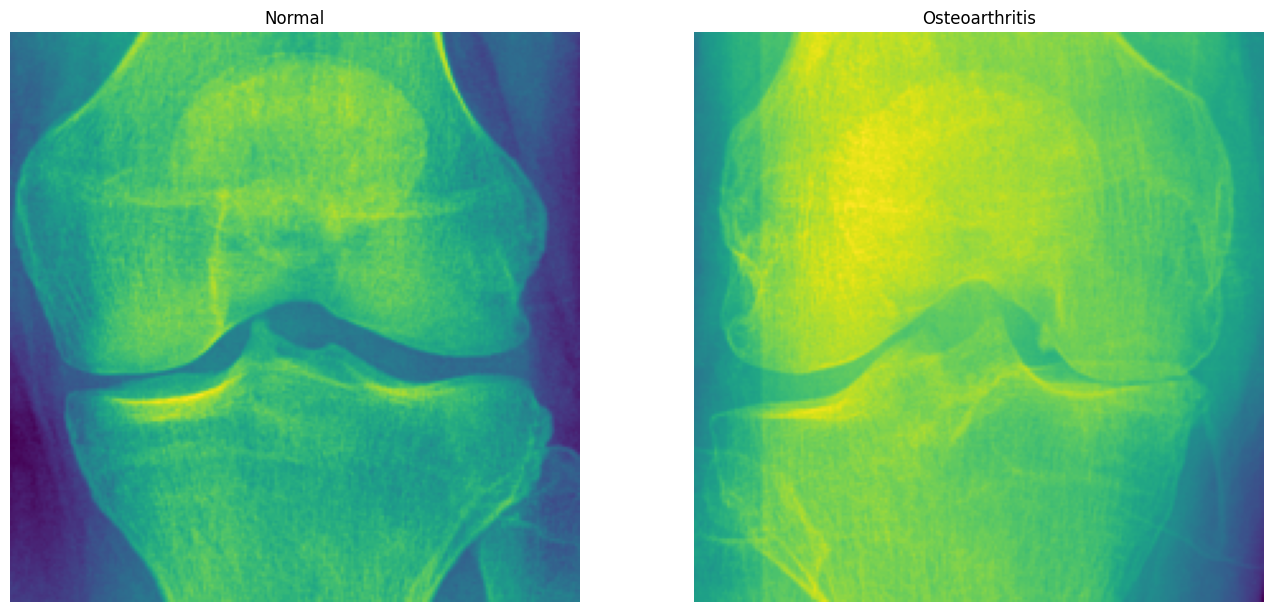



Size of the image
Category: normal
(224, 224)


Size of the image
Category: osteoarthritis
(224, 224)


In [6]:
img1 = Image.open(f"{normal['load_command']['valid'][0]}")
img2 = Image.open(f"{osteoarthritis['load_command']['valid'][0]}")

def plot_image(img):
  plt.figure(figsize=(10, 10))
  plt.imshow(img, cmap = 'gray')
  plt.axis("off")
  plt.show()

plt.figure(figsize=(25, 10))
for i in range(2):
    plt.subplot(1, 3, i+1)
    plt.imshow([img1, img2][i])
    plt.title(["Normal", "Osteoarthritis"][i])
    plt.axis("off")
plt.show()

for size,name in zip([img1.size, img2.size],categories):
    print('\n')
    print(f"Size of the image\nCategory: {name['category_name']}")
    print(size)

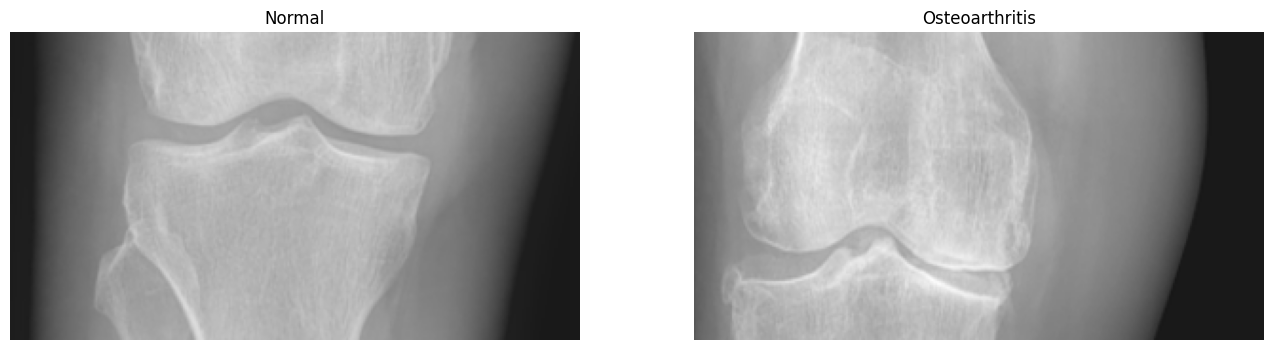



Size of the image
Category: normal
(300, 162)


Size of the image
Category: osteoarthritis
(300, 162)


In [7]:
img1 = Image.open(f"{normal['load_command']['test'][0]}")
img2 = Image.open(f"{osteoarthritis['load_command']['test'][0]}")

def plot_image(img):
  plt.figure(figsize=(10, 10))
  plt.imshow(img, cmap = 'gray')
  plt.axis("off")
  plt.show()

plt.figure(figsize=(25, 10))
for i in range(2):
    plt.subplot(1, 3, i+1)
    plt.imshow([img1, img2][i])
    plt.title(["Normal", "Osteoarthritis"][i])
    plt.axis("off")
plt.show()

for size,name in zip([img1.size, img2.size],categories):
    print('\n')
    print(f"Size of the image\nCategory: {name['category_name']}")
    print(size)

In [39]:
def load_images(img_vector, sample, img_shape=tuple):
  X,y = [],[]

  for vector in img_vector:
    # Calculate total number of images to process for the progress bar
    total_images = len(vector['load_command'][sample])

    # Create progress bar
    progress_bar = tqdm(total=total_images, desc="Loading images", unit="img")

    for images in vector['load_command'][sample]:
      img = cv2.imread(images, cv2.IMREAD_GRAYSCALE)
      # img = cv2.equalizeHist(img1_gray)
      # img = cv2.GaussianBlur(img, (5, 5), 0)
      # img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
      #                               cv2.THRESH_BINARY, 15, 4)
      img = cv2.resize(img, img_shape)
      img = img.squeeze()
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
      img = np.asarray(img)
      X.append(img)
      y.append(vector['category_name'])
      # Update progress bar
      progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()

  return X, y

In [51]:
# Inceoption_V3 load pipeline
X_train, y_train = load_images(categories, "train", (299, 299))
X_test, y_test = load_images(categories, "test", (299, 299))
X_val, y_val = load_images(categories, "valid", (299, 299))

Loading images: 100%|██████████| 431/431 [00:00<00:00, 587.18img/s]


In [52]:
print(X_train[0].shape)
print(X_test[0].shape)
print(X_val[0].shape)

(299, 299, 3)
(299, 299, 3)
(299, 299, 3)


In [54]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_val = np.asarray(X_val)


category_dict = {
    "normal": 0,
    "osteoarthritis": 1,
}

y_train = [category_dict[i] for i in y_train]
y_test = [category_dict[i] for i in y_test]
y_val = [category_dict[i] for i in y_val]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [58]:
model = Sequential()
# model.add(Rescaling(1./255))
model.add(RandomFlip("horizontal_and_vertical"))
model.add(RandomZoom(
    height_factor = (-0.5,0.5),
    width_factor = (-0.5,0.5),
))
model.add(RandomRotation(0.5))
# model.add(RandomBrightness([-0.2,0.2]))
model.add(inception_v3.InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3)))
model.add(Conv2D(128, (1,1)))
model.add(Conv2D(256, (1,1)))
model.add(Conv2D(512, (1,1)))
model.add(MaxPooling2D((2,2), padding = "same"))
model.add(SpatialDropout2D(0.4))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(64, activation = "relu"))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(2, activation = "softmax"))

In [59]:
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 8, restore_best_weights = True),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 0.0001)
]

In [60]:
model.compile(loss = keras.losses.CategoricalCrossentropy(), optimizer = keras.optimizers.Adadelta(learning_rate=0.5), metrics = ["accuracy", "categorical_accuracy"])
history_inception = model.fit(X_train, y_train, epochs = 100 , batch_size = 50, validation_data = (X_val, y_val), callbacks = callbacks)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 53s 289ms/step - accuracy: 0.5256 - categorical_accuracy: 0.5256 - loss: 0.8308 - val_accuracy: 0.6724 - val_categorical_accuracy: 0.6724 - val_loss: 3.5124 - learning_rate: 0.5000
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.5819 - categorical_accuracy: 0.5819 - loss: 0.6376 - val_accuracy: 0.6724 - val_categorical_accuracy: 0.6724 - val_loss: 1.3047 - learning_rate: 0.5000
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.6563 - categorical_accuracy: 0.6563 - loss: 0.5852 - val_accuracy: 0.6724 - val_categorical_accuracy: 0.6724 - val_loss: 0.4733 - learning_rate: 0.5000
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.7175 - categorical_accuracy: 0.7175 - loss: 0.5181 - val_accuracy: 0.7161 - val_categorical_accuracy: 0.7161 - val_loss: 0.6198 - learning_rate: 0.5000
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.7879 - categorical_accuracy: 0.7879 - loss: 0.4536 - val

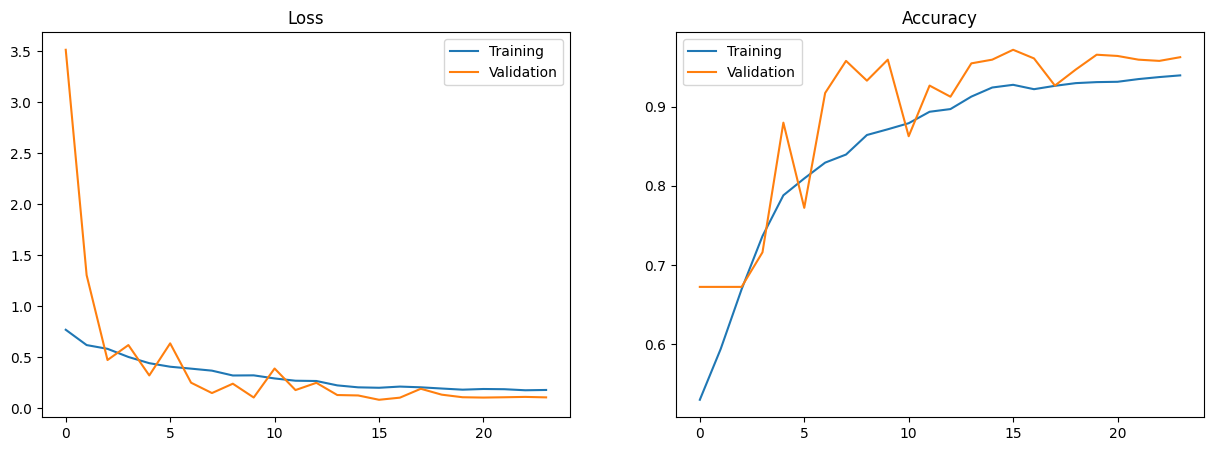

In [61]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.lineplot(ax = ax[0], data = history_inception.history["loss"], label = "Training")
sns.lineplot(ax = ax[0], data = history_inception.history["val_loss"], label = "Validation")
ax[0].set_title("Loss")
sns.lineplot(ax = ax[1], data = history_inception.history["accuracy"], label = "Training")
sns.lineplot(ax = ax[1], data = history_inception.history["val_accuracy"], label = "Validation")
ax[1].set_title("Accuracy")
plt.show()

In [62]:
model.save("osteoarthritis_inception.keras")